In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['axes.unicode_minus'] = False
import warnings
warnings.filterwarnings("ignore")
df = pd.read_excel('calculated_properties_EC.xlsx')

from sklearn.model_selection import train_test_split
X = df.drop(['alloy', 'UTS', 'EC'], axis=1)
y = df['EC']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Import necessary libraries for feature selection and model interpretation
from xgboost import XGBRegressor  # Import XGBoost regressor model for building regression models
from boruta import BorutaPy       # Import Boruta algorithm for feature selection
import shap                       # Import SHAP library for interpreting model predictions


class SHAPBorutaWrapper(XGBRegressor):
    """
    A wrapper class for XGBRegressor that extends its functionality with SHAP-based feature importance calculation.
    This class combines the power of XGBoost regression with SHAP (SHapley Additive exPlanations) values
    to determine feature importances.
    """
    def __init__(self, max_depth=None, n_estimators=100, random_state=42, **kwargs):
        super().__init__(
            max_depth=max_depth,
            n_estimators=n_estimators,
            random_state=random_state,
            **kwargs
        )
        self.shap_importances_ = None

    def fit(self, X, y):
        super().fit(X, y)
        explainer = shap.TreeExplainer(self)
        shap_values = explainer.shap_values(X)
        self.shap_importances_ = np.abs(shap_values).mean(axis=0)
        return self

    @property
    def feature_importances_(self):
        return self.shap_importances_


# Import pandas library for data manipulation
# Note: The actual import statement is not shown in the provided code
# Read the Excel file 'calculated_properties_EC.xlsx' into a pandas DataFrame
df = pd.read_excel('calculated_properties_EC.xlsx')
# Extract the target variable 'EC' (Electrical Conductivity) from the DataFrame
y = df['EC']
# Create the feature matrix X by dropping unnecessary columns:
# - 'alloy': The alloy identifier column
# - 'UTS': Ultimate Tensile Strength column (not needed for this analysis)
# - 'EC': The target variable itself (should not be in features)
X = df.drop(['alloy', 'UTS', 'EC'], axis=1)


# Set random seed for reproducibility
np.random.seed(1)  
# Randomly permute the columns of the feature matrix X
shuffled_columns = np.random.permutation(X.columns) 
# Split the shuffled columns into three equal-sized arrays
X1_cols, X2_cols, X3_cols = np.array_split(shuffled_columns, 3) 


# Extracting specific columns from the dataset X into separate DataFrames
X1 = X[X1_cols]  # Select columns for X1 subset
X2 = X[X2_cols]  # Select columns for X2 subset
X3 = X[X3_cols]  # Select columns for X3 subset


# Print the column count and column names for X1, X2, and X3
print(f"X1 列数: {len(X1_cols)}, 列名: {list(X1_cols)}")  # Display X1's column count and column names
print(f"X2 列数: {len(X2_cols)}, 列名: {list(X2_cols)}")  # Display X2's column count and column names
print(f"X3 列数: {len(X3_cols)}, 列名: {list(X3_cols)}")  # Display X3's column count and column names

def run_boruta_selection(X_part, y, part_name):
    
# Split the data into training and testing sets
# X_part: features, y: target variable
# test_size=0.2 means 20% of data will be used for testing
# random_state=42 ensures reproducibility of the split
    X_train, X_test, y_train, y_test = train_test_split(X_part, y, test_size=0.2, random_state=42)
    
    
    base_estimator = SHAPBorutaWrapper(
        n_estimators=100,
        max_depth=7,
        min_samples_split=5,
        n_jobs=-1,
        random_state=42
    )
    
    
    boruta_shap = BorutaPy(
        estimator=base_estimator,
        n_estimators='auto',
        verbose=0,  
        two_step=False,
        random_state=42,
        max_iter=100
    )
    
    
    boruta_shap.fit(np.array(X_train), y_train.values.ravel())
    
    
    feature_ranks = pd.DataFrame({
        'feature': X_train.columns,
        'rank': boruta_shap.ranking_,
        'acceptance': np.where(boruta_shap.support_, 'Confirmed',
                             np.where(boruta_shap.support_weak_, 'Tentative', 'Rejected'))
    })
    
    
    print(f"\n=== {part_name} 特征选择结果 ===")
    print("初始特征数量:", X_train.shape[1])
    print("确认选择特征:", sum(boruta_shap.support_))
    print("待定特征:", sum(boruta_shap.support_weak_))
    print("拒绝特征:", sum(~boruta_shap.support_))
    print("\n特征排序详情:")
    print(feature_ranks.sort_values('rank'))
    
    
    selected_features = X_train.columns[boruta_shap.support_].tolist()
    selected_features_unsure = X_train.columns[boruta_shap.support_weak_].tolist()
    
    if selected_features_unsure:
        print(f"\n{part_name} 待定特征:", selected_features_unsure)
    print(f"{part_name} 最终选定特征:", selected_features)
    selected_features2 = selected_features_unsure + selected_features
    return selected_features2,feature_ranks,boruta_shap

# Run the Boruta selection process for each subset of features
selected_X1, _, boruta_X1 = run_boruta_selection(X1, y, "X1")
selected_X2, _, boruta_X2 = run_boruta_selection(X2, y, "X2")
selected_X3, _, boruta_X3 = run_boruta_selection(X3, y, "X3")


X1 列数: 69, 列名: ['P20', 'O17', 'E9_1', 'E4', 'S28', 'P9', 'O18', 'S6', 'E10_1', 'P4', 'B5', 'P12_1', 'O15_1', 'S26', 'S17', 'P10_1', 'O8_1', 'S21', 'S22_1', 'E3_1', 'P13_1', 'S19', 'B12', 'S5_1', 'P9_1', 'S22', 'O4', 'O2_1', 'S6_1', 'S23', 'P3_1', 'S16', 'S4', 'S16_1', 'S2_1', 'P22_1', 'S15', 'E7', 'E18', 'PP', 'S24_1', 'B5_1', 'O10', 'E5_1', 'O3_1', 'O15', 'P15', 'E11', 'S3_1', 'B2_1', 'P11', 'B6_1', 'S2', 'P2_1', 'P1', 'S7', 'P17_1', 'S27', 'B9_1', 'P4_1', 'E16', 'P16_1', 'S10_1', 'P21_1', 'E12_1', 'E13', 'O14', 'E1_1', 'B4_1']
X2 列数: 68, 列名: ['S18_1', 'E2', 'S5', 'B6', 'E8_1', 'O17_1', 'E8', 'P5_1', 'P8', 'B13_1', 'E14', 'O13', 'S8_1', 'O9', 'P11_1', 'S9_1', 'B13', 'S13_1', 'B1_1', 'O14_1', 'E17_1', 'O19', 'O1', 'O6_1', 'O12_1', 'S1', 'O2', 'P19_1', 'O1_1', 'E5', 'B7_1', 'S24', 'P6_1', 'O9_1', 'E16_1', 'B11_1', 'E11_1', 'O20_1', 'S4_1', 'O16_1', 'P17', 'S9', 'O11', 'O4_1', 'B3', 'P12', 'O5', 'E13_1', 'B7', 'P7_1', 'B1', 'E18_1', 'P19', 'B12_1', 'P7', 'E15', 'O18_1', 'O8', 'O7_1', 'E6

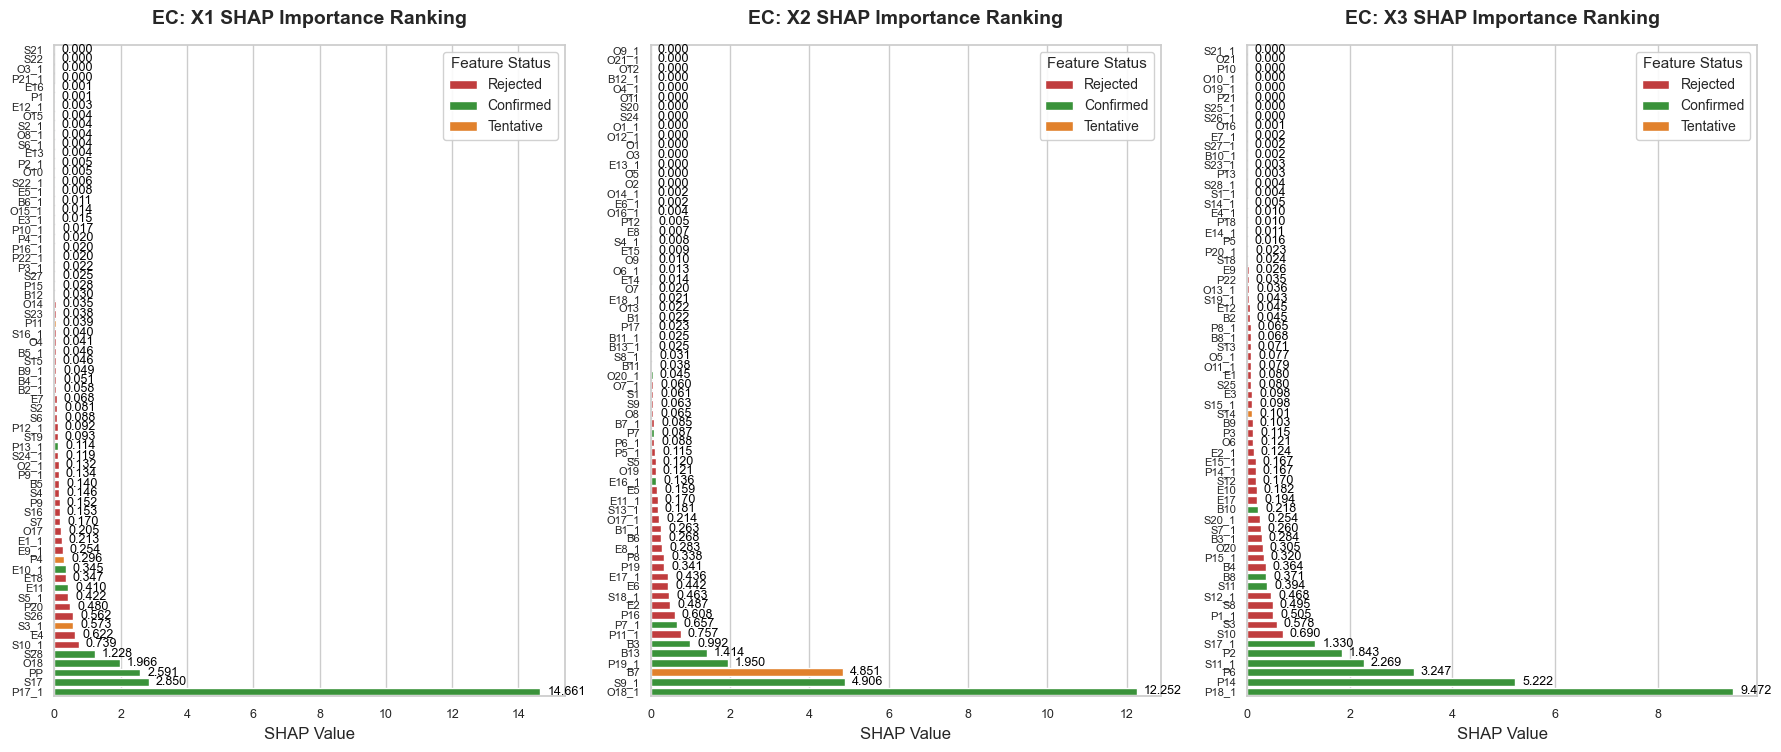

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib import rcParams

def calculate_shap_importances(X_part, y, boruta_instance):
    # boruta_instance: BorutaPy
    features = X_part.columns
    support = boruta_instance.support_
    support_weak = boruta_instance.support_weak_
    
    # status = []
    status = []
    for i in range(len(features)):
        if support[i]:
            status.append('Confirmed')
        elif support_weak[i]:
            status.append('Tentative')
        else:
            status.append('Rejected')
    
# Initialize the XGBoost Regressor model with specified hyperparameters
    model = XGBRegressor(
        n_estimators=100,    # Number of boosting rounds (trees) to be built
        max_depth=7,         # Maximum depth of each tree, controlling model complexity
        random_state=42      # Random seed for reproducibility of results
    )
# Fit the model to the training data
# X_part: Training features (subset of the dataset)
# y: Target values corresponding to the training features
    model.fit(X_part, y)
    
# Create a SHAP explainer object for tree-based models
    explainer = shap.TreeExplainer(model)
# Calculate SHAP values for the subset of data X_part
    shap_values = explainer.shap_values(X_part)
# Compute mean absolute SHAP values across all samples to get feature importances
    shap_importances = np.abs(shap_values).mean(axis=0)
    
    
# Create a DataFrame using pandas to store SHAP values and related information
    df_shap = pd.DataFrame({
        'Feature': features,
        'SHAP_Value': shap_importances,
        'Status': status
    })
    
    return df_shap.sort_values('SHAP_Value', ascending=True)

rcParams['font.family'] = 'Times New Roman'
rcParams['axes.titleweight'] = 'bold'
sns.set(style="whitegrid")  


# Calculate SHAP importances for different feature sets
shap_X1 = calculate_shap_importances(X1, y, boruta_X1)  # SHAP values for feature set X1
shap_X2 = calculate_shap_importances(X2, y, boruta_X2)  # SHAP values for feature set X2
shap_X3 = calculate_shap_importances(X3, y, boruta_X3)  # SHAP values for feature set X3


plt.figure(figsize=(18, 8))


colors = {'Confirmed': '#2ca02c', 
          'Tentative': '#ff7f0e', 
          'Rejected': '#d62728'}


# Iterate through multiple datasets and their corresponding data
# using enumeration to get both index and values
for i, (dataset, data) in enumerate(zip(['X1', 'X2', 'X3'], 
                                        # List of SHAP values for each dataset
                                        [shap_X1, shap_X2, shap_X3])):
    

# Sort the data based on SHAP values in ascending order
    sorted_data = data.sort_values('SHAP_Value', ascending=True)
    
   
# Create a subplot for the current iteration
    ax = plt.subplot(1, 3, i+1)
    
    
# Create a horizontal bar plot using seaborn
    sns.barplot(
        x='SHAP_Value',          # x-axis represents SHAP values
        y='Feature',             # y-axis represents feature names
        data=sorted_data,        # use the sorted data
        hue='Status',            # color bars based on feature status
        palette=colors,         # use predefined color palette
        orient='h',              # horizontal orientation
        ax=ax                   # specify the axis to plot on
    )
    
   
# Add value labels to the bars
    for p in ax.containers:
        ax.bar_label(p, fmt='%.3f', padding=5, fontsize=9, 
                    label_type='edge', color='black')
   

   
# Customize y-axis ticks
    ax.tick_params(axis='y',               # apply to y-axis
                  labelsize=8,              # set tick label size
                  labelrotation=0,          # no rotation
                  pad=2)                  # padding between ticks and labels

# Customize x-axis ticks
    ax.tick_params(axis='x', labelsize=9)  # set x-axis tick label size
  
# Set plot title and labels
    ax.set_title(f'EC: {dataset} SHAP Importance Ranking', 
                fontsize=14, pad=15, fontweight='bold')  # bold title with padding
    ax.set_xlabel('SHAP Value', fontsize=12)  # x-axis label
    ax.set_ylabel('')  # no y-axis label
    
    
# Configure the legend
    ax.legend(
        title='Feature Status',         # legend title
        title_fontsize=11,             # title font size
        fontsize=10,                   # label font size
        loc='upper right',               # position
        bbox_to_anchor=(1.0, 1.0),       # exact position
        frameon=True,                    # show frame
        framealpha=0.9                   # frame transparency
    )

    


# Adjust subplot spacing and layout
    plt.subplots_adjust(wspace=0.4)      # width space between subplots
    plt.tight_layout(rect=[0, 0, 1, 0.96])    # adjust layout with specified rectangle

plt.show()

In [ ]:
# Merge all tentative and final selected features
all_selected_features = set(selected_X1 + selected_X2 + selected_X3)
X4 = X[list(all_selected_features)]

# Perform Boruta feature selection on X4 again
print("\n=== Final feature selection on merged features X4 ===")
selected_X4 = run_boruta_selection(X4, y, "X4")

# Get SHAP values and sort
base_estimator = SHAPBorutaWrapper(
    n_estimators=100,
    max_depth=7,
    min_samples_split=5,
    n_jobs=-1,
    random_state=42
)
base_estimator.fit(X4, y)

# Create DataFrame with SHAP value ranking
shap_ranking = pd.DataFrame({
    'feature': X4.columns,
    'shap_value': base_estimator.shap_importances_
}).sort_values('shap_value', ascending=False)

# Output results sorted by SHAP values
print("\n=== Final features sorted by SHAP values ===")
print(shap_ranking)

# Create DataFrame with SHAP value ranking
shap_ranking = pd.DataFrame({
    'feature': X4.columns,
    'shap_value': base_estimator.shap_importances_
}).sort_values('shap_value', ascending=False)

# Extract top 10 features (newly added code)
top_10_shap_features = shap_ranking.head(6)

# Print top 10 features
print("\n=== Final features sorted by SHAP values (top 10) ===")
print(top_10_shap_features)


=== 对合并特征X4进行最终特征选择 ===

=== X4 特征选择结果 ===
初始特征数量: 33
确认选择特征: 12
待定特征: 2
拒绝特征: 21

特征排序详情:
   feature  rank acceptance
0       P2     1  Confirmed
30   E10_1     1  Confirmed
28     S28     1  Confirmed
25      PP     1  Confirmed
20   P19_1     1  Confirmed
18   S25_1     1  Confirmed
14   O18_1     1  Confirmed
11     B13     1  Confirmed
10   O20_1     1  Confirmed
16     E11     1  Confirmed
1       P7     1  Confirmed
2    P17_1     1  Confirmed
13    S3_1     2  Tentative
3     P7_1     2  Tentative
6      P11     3   Rejected
12    O8_1     4   Rejected
4      B10     4   Rejected
8    P18_1     6   Rejected
7      P14     7   Rejected
9       B3     8   Rejected
17      P4     9   Rejected
31     S17    10   Rejected
22    S9_1    11   Rejected
21     S14    12   Rejected
19      B7    13   Rejected
26      P6    14   Rejected
5       B8    15   Rejected
23     S11    15   Rejected
24   S11_1    17   Rejected
32   E16_1    18   Rejected
27   S17_1    19   Rejected
29   P13_1  


=== X4 特征选择结果 ===
初始特征数量: 33
确认选择特征: 12
待定特征: 2
拒绝特征: 21

特征排序详情:
   feature  rank acceptance
0       P2     1  Confirmed
30   E10_1     1  Confirmed
28     S28     1  Confirmed
25      PP     1  Confirmed
20   P19_1     1  Confirmed
18   S25_1     1  Confirmed
14   O18_1     1  Confirmed
11     B13     1  Confirmed
10   O20_1     1  Confirmed
16     E11     1  Confirmed
1       P7     1  Confirmed
2    P17_1     1  Confirmed
13    S3_1     2  Tentative
3     P7_1     2  Tentative
6      P11     3   Rejected
12    O8_1     4   Rejected
4      B10     4   Rejected
8    P18_1     6   Rejected
7      P14     7   Rejected
9       B3     8   Rejected
17      P4     9   Rejected
31     S17    10   Rejected
22    S9_1    11   Rejected
21     S14    12   Rejected
19      B7    13   Rejected
26      P6    14   Rejected
5       B8    15   Rejected
23     S11    15   Rejected
24   S11_1    17   Rejected
32   E16_1    18   Rejected
27   S17_1    19   Rejected
29   P13_1    20   Rejected
15     O1

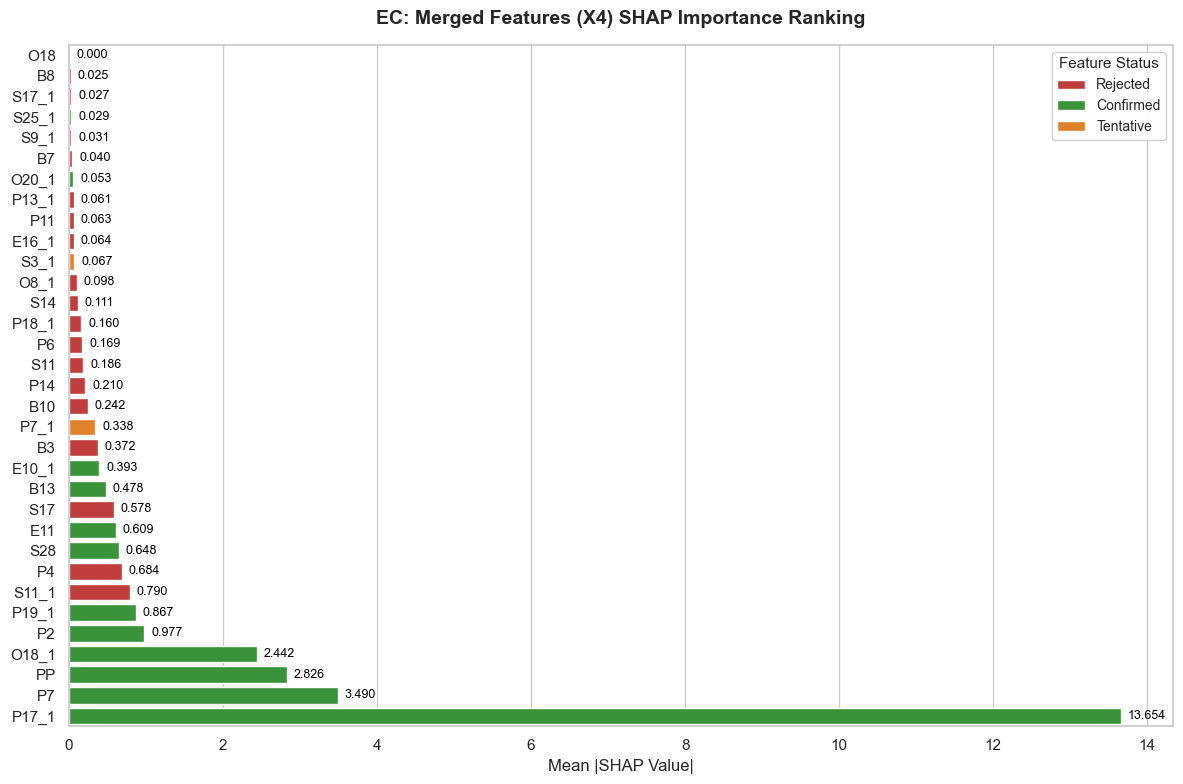

In [ ]:
# Perform feature selection on X4 and get Boruta instance and feature status
selected_X4, feature_ranks_X4, boruta_X4 = run_boruta_selection(X4, y, "X4")

# Generate SHAP data for X4
def calculate_shap_importances_X4(X_part, y, boruta_instance):
    # Get feature support status
    features = X_part.columns
    support = boruta_instance.support_
    support_weak = boruta_instance.support_weak_
    
    # Create feature status list
    status = []
    for i in range(len(features)):
        if support[i]:
            status.append('Confirmed')
        elif support_weak[i]:
            status.append('Tentative')
        else:
            status.append('Rejected')
    
    # Train new model to calculate SHAP
    model = XGBRegressor(
        n_estimators=100,
        max_depth=7,
        random_state=42
    )
    model.fit(X_part, y)
    
    # Calculate SHAP values
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_part)
    shap_importances = np.abs(shap_values).mean(axis=0)
    
    # Create result DataFrame
    return pd.DataFrame({
        'Feature': features,
        'SHAP_Value': shap_importances,
        'Status': status
    }).sort_values('SHAP_Value', ascending=True)

# Generate SHAP data for X4
shap_X4 = calculate_shap_importances_X4(X4, y, boruta_X4)

# Plot SHAP importance chart for X4
plt.figure(figsize=(12, 8))
colors = {'Confirmed': '#2ca02c', 'Tentative': '#ff7f0e', 'Rejected': '#d62728'}

ax = sns.barplot(
    x='SHAP_Value',
    y='Feature',
    data=shap_X4,
    hue='Status',
    palette=colors,
    orient='h'
)

# Add data labels
for p in ax.containers:
    ax.bar_label(p, fmt='%.3f', padding=5, fontsize=9, 
                label_type='edge', color='black')

# Set title and axes
plt.title('EC: Merged Features (X4) SHAP Importance Ranking', 
        fontsize=14, pad=15, fontweight='bold')
plt.xlabel('Mean |SHAP Value|', fontsize=12)
plt.ylabel('')

# Set legend
ax.legend(
        title='Feature Status',
        title_fontsize=11,
        fontsize=10,
        loc='upper right',  # Place in upper right corner
        bbox_to_anchor=(1.0, 1.0),  # Fine-tune position
        frameon=True,  # Show border
        framealpha=0.9  # Border transparency
    )

plt.tight_layout()
plt.show()

posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


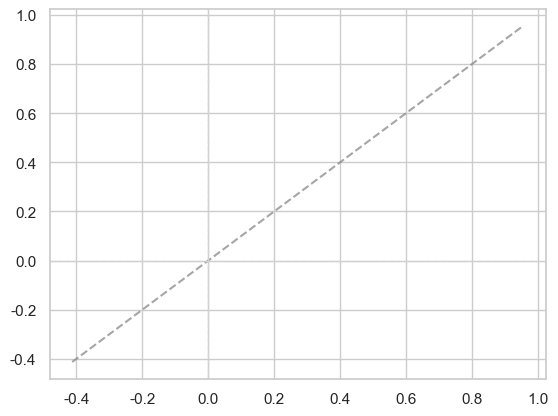

posx and posy should be finite values
posx and posy should be finite values


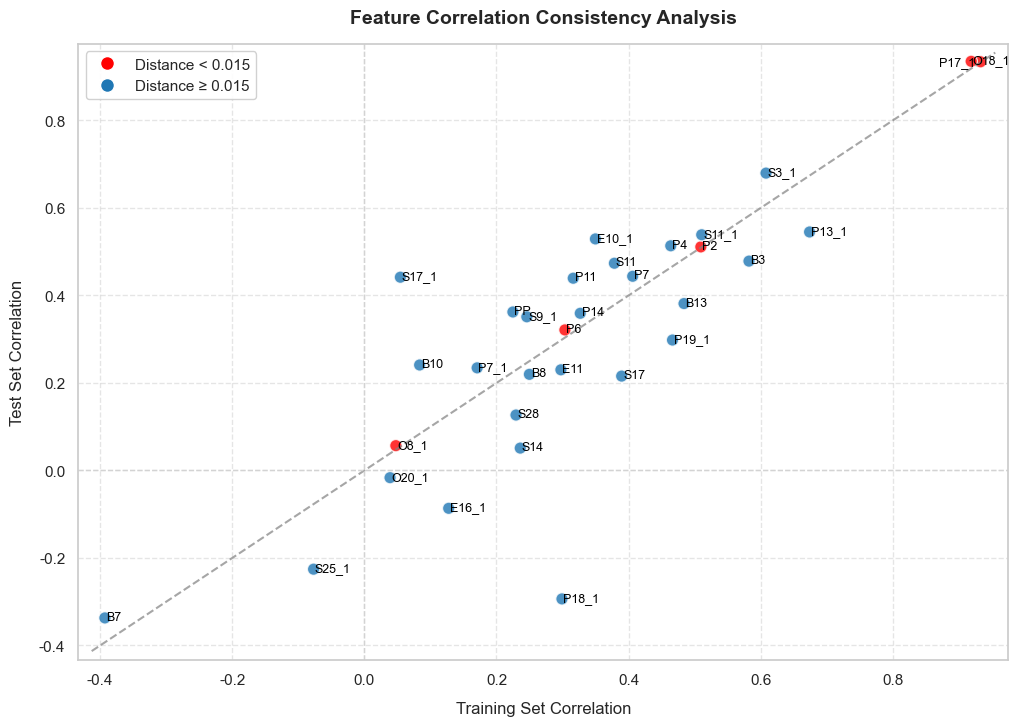

In [ ]:
from sklearn.model_selection import train_test_split
# Split features and target variables
X = X4
y = df['EC']
# Split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=22)
# The subsequent SHAP analysis part remains unchanged
xgboost = SHAPBorutaWrapper(
    n_estimators=100,
    max_depth=7,
    min_samples_split=5,
    n_jobs=-1,
    random_state=42
)
xgboost.fit(X4, y)

import shap
explainer = shap.TreeExplainer(xgboost)
# Calculate shap values as numpy.array
shap_train = explainer.shap_values(X_train)
shap_train = pd.DataFrame(shap_train, columns=X_train.columns)
# Calculate shap values as numpy.array
shap_test = explainer.shap_values(X_test)
shap_test = pd.DataFrame(shap_test, columns=X_test.columns)
from scipy.stats import pointbiserialr

# For each feature column, calculate its point-biserial correlation coefficient with y_train and y_test

# Calculate point-biserial correlation coefficient between shap_train and y_train
train_correlations = []
for column in shap_train.columns:
    correlation, _ = pointbiserialr(shap_train[column], y_train)
    train_correlations.append((column, correlation))

# Calculate point-biserial correlation coefficient between shap_test and y_test
test_correlations = []
for column in shap_test.columns:
    correlation, _ = pointbiserialr(shap_test[column], y_test)
    test_correlations.append((column, correlation))

# Save results as DataFrame
train_corr_df = pd.DataFrame(train_correlations, columns=['Feature', 'Point-Biserial Correlation'])
test_corr_df = pd.DataFrame(test_correlations, columns=['Feature', 'Point-Biserial Correlation'])
# Dynamically calculate axis range (add before plotting)
all_train = train_corr_df['Point-Biserial Correlation']
all_test = test_corr_df['Point-Biserial Correlation']

# Include 0 point when calculating min/max values
x_min = min(all_train.min(), all_test.min(), 0) - 0.02
x_max = max(all_train.max(), all_test.max(), 0) + 0.02
y_min = x_min  # Use same range to ensure symmetric axes
y_max = x_max

# Draw reference lines (corrected code)
plt.plot([x_min, x_max], [x_min, x_max], '--', color='gray', alpha=0.7)
plt.axhline(0, color='lightgrey', linestyle='--', linewidth=1)
plt.axvline(0, color='lightgrey', linestyle='--', linewidth=1)
# Calculate Euclidean distance
distances = [abs(train_row - test_row)/np.sqrt(2) 
            for train_row, test_row in zip(
                train_corr_df['Point-Biserial Correlation'],
                test_corr_df['Point-Biserial Correlation']  # Complete right parenthesis
            )] 
# Create color list (red: distance<0.015, blue: others)
colors = ['#ff0000' if d < 0.015 else '#1f77b4' for d in distances]  # Use standard red and blue

plt.figure(figsize=(12, 8))  # Increase canvas size

# Draw scatter plot (with color distinction)
sc = plt.scatter(
    train_corr_df['Point-Biserial Correlation'],
    test_corr_df['Point-Biserial Correlation'],
    c=colors,                   # Use color list
    s=80,                       # Increase point size
    edgecolors='w',             # Add white border
    linewidths=1,               # Border width
    alpha=0.8                   # Transparency
)

# Annotate feature names (optimized display)
# Annotate feature names (optimized display)
for i, feature in enumerate(train_corr_df['Feature']):
    x = train_corr_df['Point-Biserial Correlation'].iloc[i]
    y = test_corr_df['Point-Biserial Correlation'].iloc[i]

    if feature == 'P17_1':
        x_offset = -0.008  # Shift left
        y_offset = 0       # Vertical center
        ha = 'right'
        va = 'center'
    else:
        x_offset = 0.002   # Shift right
        y_offset = 0.002   # Slightly upward
        ha = 'left'
        va = 'center'

    plt.text(
        x + x_offset,
        y + y_offset,
        feature,
        fontsize=9,
        color='black',
        va=va,
        ha=ha,
        fontweight='normal'
    )

# Draw reference lines (keep original)
plt.plot([x_min, x_max], [x_min, x_max], '--', color='gray', alpha=0.7)
plt.axhline(0, color='lightgrey', linestyle='--', linewidth=1)
plt.axvline(0, color='lightgrey', linestyle='--', linewidth=1)

# Add legend (explain color meaning)
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', label='Distance < 0.015',
              markerfacecolor='#ff0000', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='Distance ≥ 0.015',
              markerfacecolor='#1f77b4', markersize=10)
]
plt.legend(handles=legend_elements, loc='upper left', framealpha=0.9)

# Optimize axis labels
plt.xlabel("Training Set Correlation", fontsize=12, labelpad=10)
plt.ylabel("Test Set Correlation", fontsize=12, labelpad=10)
plt.title("Feature Correlation Consistency Analysis", 
         fontsize=14, pad=15, fontweight='bold')

# Set axis range (dynamically calculated)
buffer = 0.02  # Reduce buffer
plt.xlim(min(x_min, y_min)-buffer, max(x_max, y_max)+buffer)
plt.ylim(min(x_min, y_min)-buffer, max(x_max, y_max)+buffer)

plt.grid(True, linestyle='--', alpha=0.5)  # Add grid lines
plt.savefig("correlation_analysis.pdf", dpi=1200, bbox_inches='tight')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Create a 2x3 subplot layout
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

# Flatten axes to a 1D array for easy iteration
axes = axes.flatten()

# Define labels
labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)']

# Draw content for each subplot and add labels
for i, ax in enumerate(axes):
    # Example plot content: draw random data (please replace with your own plotting logic)
    x = np.linspace(0, 10, 100)
    y = np.sin(x + i)
    ax.plot(x, y, label=f'Curve {i+1}')
    ax.set_title(f"Subplot {i+1}")
    
    # Add labels (a)-(f) to the top-left corner of each subplot
    ax.text(0.02, 0.9, labels[i], transform=ax.transAxes,
            fontsize=12, fontweight='bold', va='top')

# Automatically adjust subplot spacing
plt.tight_layout()

# Display the figure
plt.show()

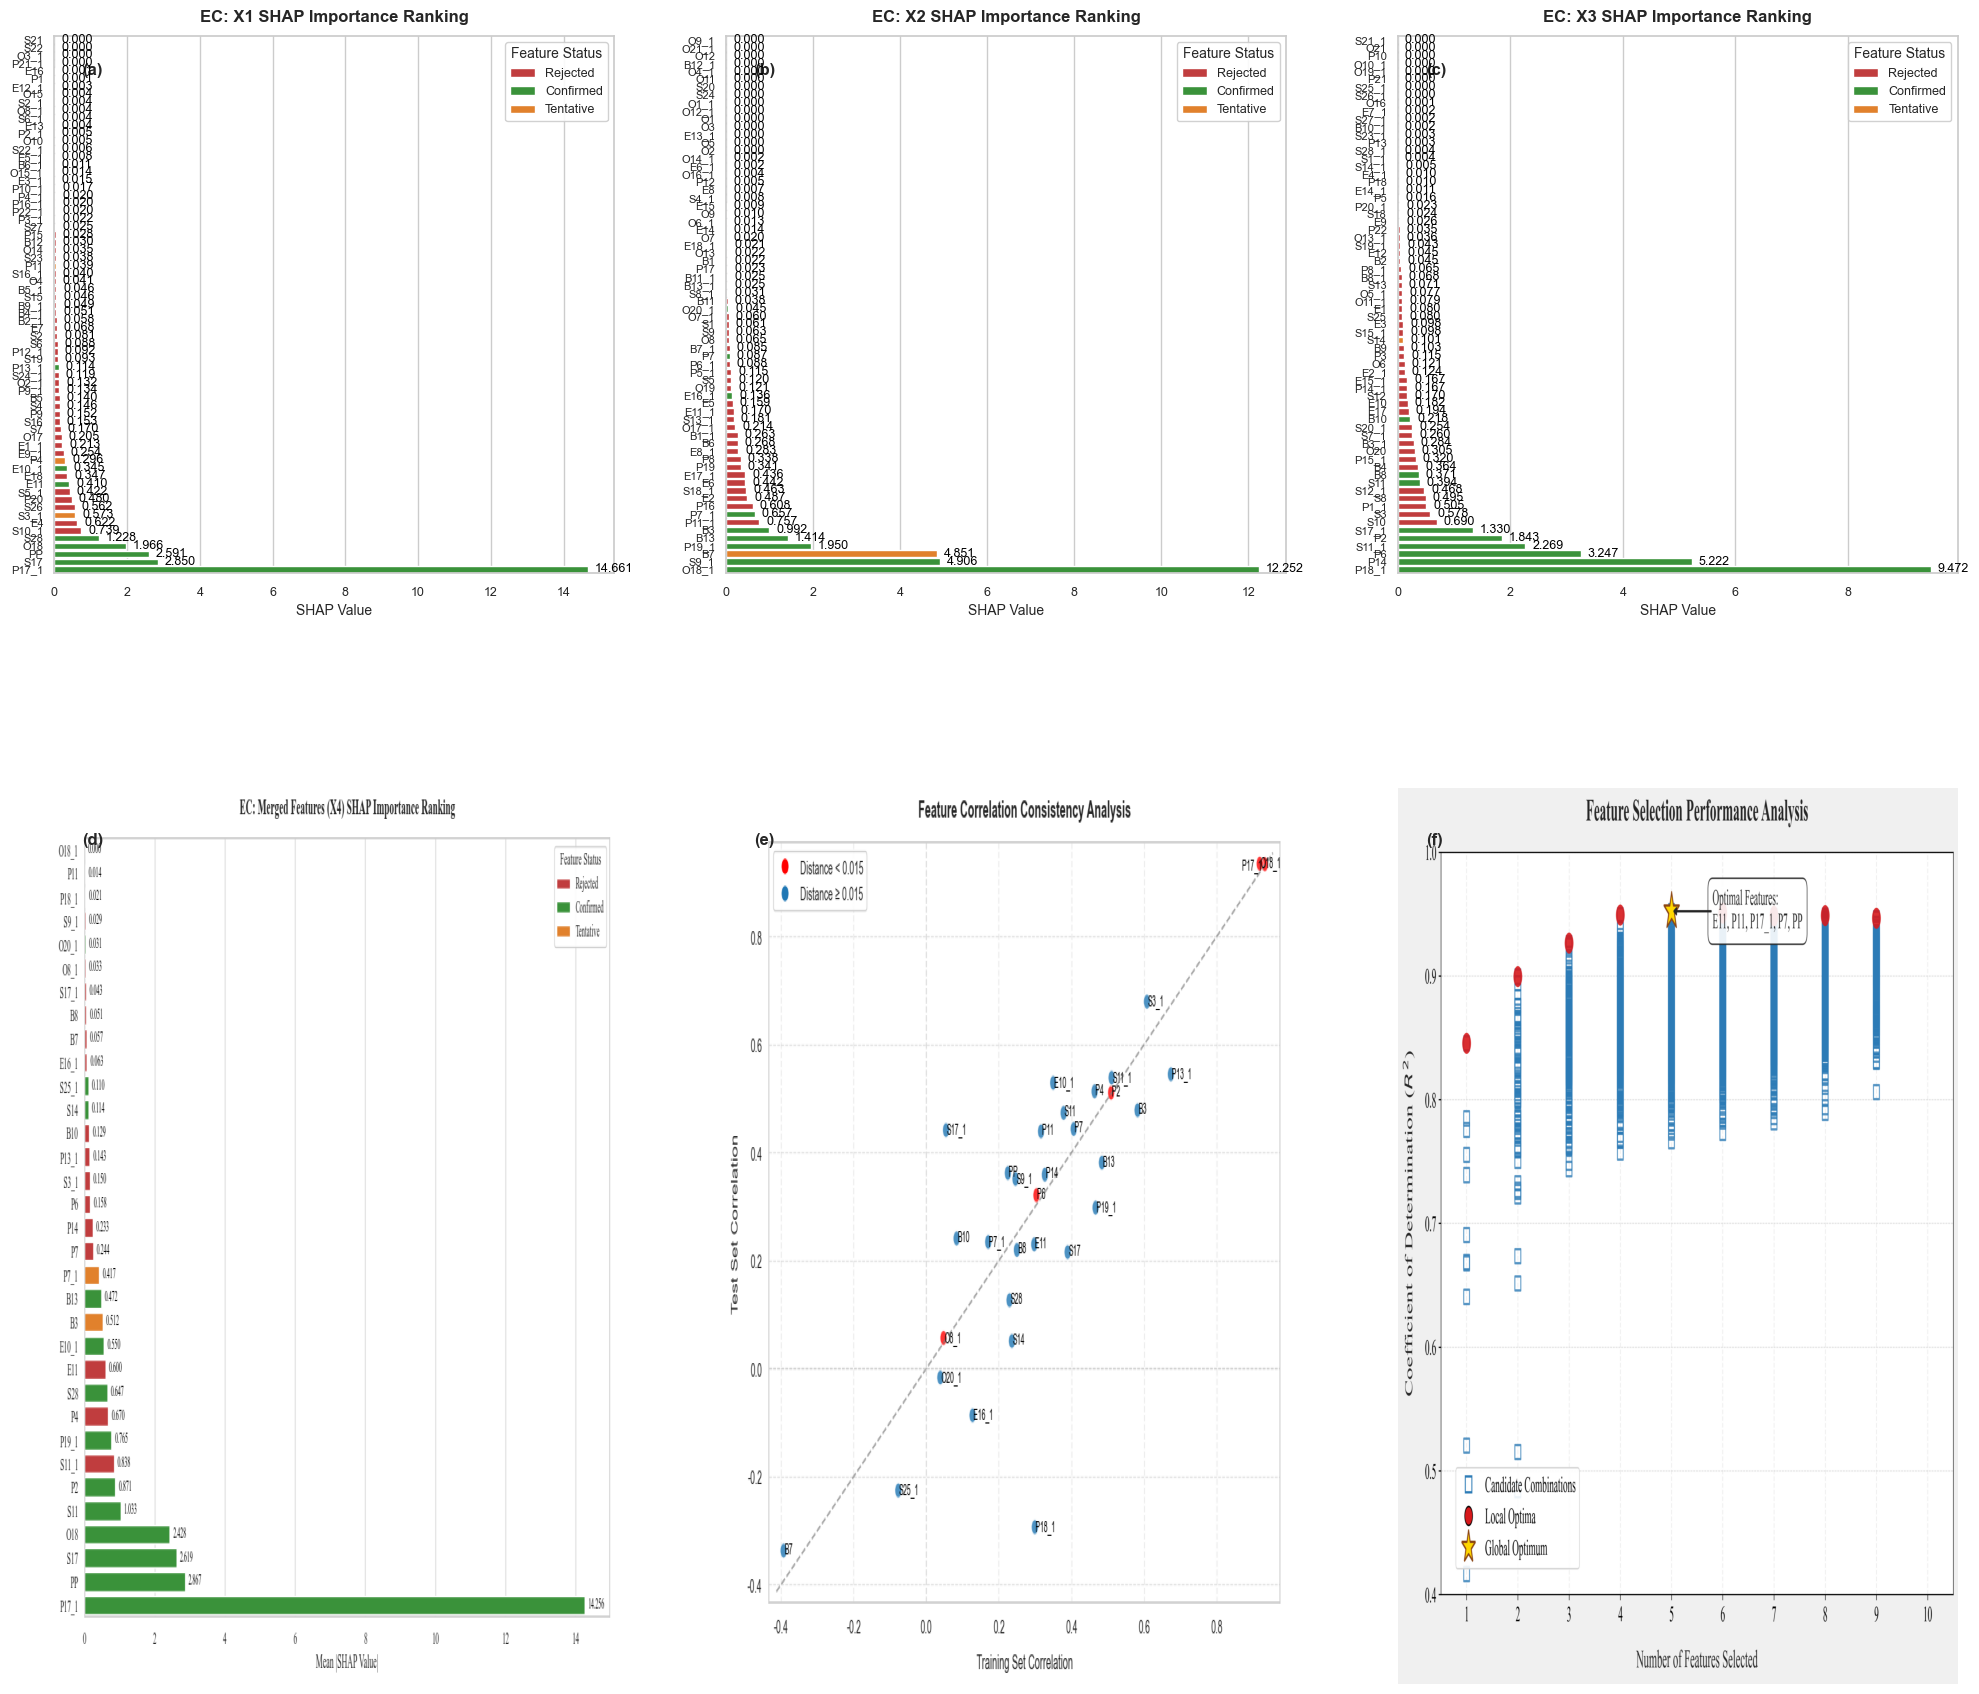

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib import rcParams
import numpy as np
from xgboost import XGBRegressor
import shap

# Assume calculate_shap_importances function and boruta_X1, boruta_X2, boruta_X3 are already defined

# Set global plotting parameters
rcParams['font.family'] = 'Times New Roman'
rcParams['axes.titleweight'] = 'bold'
sns.set(style="whitegrid")

# Create canvas (2x3 layout), increase height to accommodate images
fig, axs = plt.subplots(2, 3, figsize=(20, 18),
                        gridspec_kw={'height_ratios': [1.5, 2.5]})  # Second row is taller

# Add labels (a)-(f)
letters = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)']
for i in range(2):
    for j in range(3):
        axs[i, j].text(0.05, 0.95, letters[i * 3 + j],
                       transform=axs[i, j].transAxes,
                       fontsize=12, fontweight='bold',
                       va='top', ha='left')

# Define color scheme
colors = {'Confirmed': '#2ca02c', 
          'Tentative': '#ff7f0e', 
          'Rejected': '#d62728'}

# Plot first row SHAP charts
for idx, (dataset, data) in enumerate(zip(['X1', 'X2', 'X3'], 
                                        [shap_X1, shap_X2, shap_X3])):
    
    ax = axs[0, idx]
    sorted_data = data.sort_values('SHAP_Value', ascending=True)
    
    # Plot horizontal bar chart
    sns.barplot(
        x='SHAP_Value',
        y='Feature',
        data=sorted_data,
        hue='Status',
        palette=colors,
        orient='h',
        ax=ax
    )
    
    # Add data labels
    for p in ax.containers:
        ax.bar_label(p, fmt='%.3f', padding=5, fontsize=9, 
                    label_type='edge', color='black')
    
    # Set axis parameters
    ax.tick_params(axis='y', 
                  labelsize=8, 
                  labelrotation=0, 
                  pad=2)
    ax.tick_params(axis='x', labelsize=9)
    
    # Set title and axis labels
    ax.set_title(f'EC: {dataset} SHAP Importance Ranking', 
                fontsize=12, pad=10, fontweight='bold')
    ax.set_xlabel('SHAP Value', fontsize=10)
    ax.set_ylabel('')
    
    # Set legend
    ax.legend(
        title='Feature Status',
        title_fontsize=10,
        fontsize=9,
        loc='upper right',  
        bbox_to_anchor=(1.0, 1.0),  
        frameon=True,  
        framealpha=0.9  
    )

# Plot second row images
image_paths = ['ec-bsx-x4.png', 'ec-correlation.png', 'enhanced_plot.png']
for idx, img_path in enumerate(image_paths):
    ax = axs[1, idx]
    img = plt.imread(img_path)
    ax.imshow(img, aspect='auto')  # Auto scale to fit subplot
    ax.axis('off')  # Hide axes

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.subplots_adjust(hspace=0.3, wspace=0.2)

plt.show()